 ### Matrix Factorization
We will be using movie lens dataset for trying out how matrix factorization works. 

The idea is to extract features for users and movies which may or may not exist as a physical feature but are an approximation.

We want to "break" / reduce the dimensions of the *users X movies* matrix into two matrices with reduced (selected number of) dimensions.

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
# reading movie lens dataset

df = pd.read_csv(r'../large_files/movielens-20m-dataset/rating.csv')
df = df.drop('timestamp',axis = 1)
number_of_ratings  = df.shape[0]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 457.8 MB


In [3]:
df.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [4]:
print(f'Unique users : {df.userId.nunique()} and unique movies : {df.movieId.nunique()}')

Unique users : 138493 and unique movies : 26744


In [5]:
# Calculating cumulative percentages of ratings received at user level

userId_rating_count = df.userId.value_counts().reset_index().rename(columns = {'index':'UserId','userId':'Cnt_Movies_Rated'}).sort_values(by = 'Cnt_Movies_Rated',ascending = False)
userId_rating_count['Cumulative_Perc'] = userId_rating_count.Cnt_Movies_Rated.cumsum()/number_of_ratings

userids_at_80 = userId_rating_count.loc[userId_rating_count['Cumulative_Perc'] <= 0.4,'UserId']
print(f'Number of users who have given 40% of the total ratings : {len(userids_at_80)} and is {round(len(userids_at_80)*100/df.userId.nunique(),2)}% of total user base')

Number of users who have given 40% of the total ratings : 10691 and is 7.72% of total user base


In [6]:
# Calculating cumulative percentages of ratings received at movie level

movieId_rating_count = df.movieId.value_counts().reset_index().rename(columns = {'index':'MovieId','movieId':'Cnt_Users_Rated'}).sort_values(by = 'Cnt_Users_Rated',ascending = False)
movieId_rating_count['Cumulative_Perc'] = movieId_rating_count.Cnt_Users_Rated.cumsum()/number_of_ratings

movieids_at_80 = movieId_rating_count.loc[movieId_rating_count['Cumulative_Perc'] <= 0.80,'MovieId']
print(f'Number of movies which received 80% of the total ratings : {len(movieids_at_80)} and is {round(len(movieids_at_80)*100/df.movieId.nunique(),2)}% of total movie base')

Number of movies which received 80% of the total ratings : 1948 and is 7.28% of total movie base


In [7]:
# subsetting dataset for selected userids and movieids

df = df.loc[(df['userId'].isin(userids_at_80)) & (df['movieId'].isin(movieids_at_80))]
print(f'Number of ratings after using top 80% users and movies : {df.shape[0]/number_of_ratings * 100 :.2f}%')

Number of ratings after using top 80% users and movies : 27.85%


In [8]:
# dividing data to train test
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)

In [9]:
userId_key_dict = pd.DataFrame({'userId':list(train.userId.unique()), 'newuId':list(range(len(train.userId.unique())))})
movieId_key_dict = pd.DataFrame({'movieId':list(train.movieId.unique()), 'newmId':list(range(len(train.movieId.unique())))})

train = pd.merge(train,userId_key_dict, on = 'userId', how = 'left')
train = pd.merge(train,movieId_key_dict, on = 'movieId', how = 'left')

test = pd.merge(test,userId_key_dict, on = 'userId', how = 'left')
test = pd.merge(test,movieId_key_dict, on = 'movieId', how = 'left')

In [10]:
train.head()

,userId,movieId,rating,newuId,newmId
0,92200,2724,1.0,0,0
1,43545,1029,3.0,1,1
2,49068,1230,4.0,2,2
3,29893,778,3.5,3,3
4,119445,349,3.0,4,4


We will create users and movies matrix, add user and bias terms of size n and m, and average movie rating as *"mu"*

The derivations of the same are not discussed here.

In [11]:
n = len(train.userId.unique())
m = len(train.movieId.unique())
mt = len(test.movieId.unique())
d = 10

wu = np.random.rand(n,d)
wm = np.random.rand(m,d)

reg = 20

b = np.zeros(n)
c = np.zeros(m)
mu = train.rating.mean()

In [12]:
epochs = 30

In [13]:
def predict(u,m,mu):
    pred = wu[u].dot(wm[m]) + b[u] + c[m] + mu
    return pred

In [14]:
train_loss = []
test_loss = []

for e in range(epochs):

    ts = time.process_time()

    for i in range(n):
        ratings = train.loc[train.newuId==i].rating.values
        movies = train.loc[train.newuId==i].newmId.values
        vector = (ratings - b[i] - c[movies] - mu).dot(wm[movies])
        matrix = wm[movies].T.dot(wm[movies])
        matrix = matrix + np.eye(d) + reg
        wu[i] = np.linalg.solve(matrix,vector)

        b[i] = sum(ratings - wu[i].dot(wm[movies].T) - c[movies] - mu)/(len(movies) + reg)

        #if i%2000 == 0:
        #    print(f'Completed {i*100/n:.2f}%')

    for j in range(m):
        ratings = train.loc[train.newmId==j].rating.values
        users = train.loc[train.newmId==j].newuId.values
        vector = (ratings - b[users] - c[j] - mu).dot(wu[users])
        matrix = wu[users].T.dot(wu[users])
        matrix = matrix + np.eye(d) + reg
        wm[j] = np.linalg.solve(matrix,vector)

        c[j] = sum(ratings - wm[j].dot(wu[users].T) - b[users] - mu)/(len(users) + reg)

        #if j%500 == 0:
        #    print(f'Completed {j*100/m:.2f}%')
    
    train_error = 0
    test_error = 0
    for j in range(m):
        users = train.loc[train.newmId==j].newuId.values
        rating = train.loc[train.newmId==j].rating.values
        train_error += sum((predict(users,j, mu) - rating) ** 2)
    
    for j in range(mt):
        users = test.loc[test.newmId==j].newuId.values
        rating = test.loc[test.newmId==j].rating.values
        test_error += sum((predict(users,j, mu) - rating) ** 2)
    
    train_loss.append(train_error/train.shape[0])
    test_loss.append(test_error/test.shape[0])
    te = time.process_time()
    print(f' training time for epoch {e} : {round((te - ts)/60,2)} minutes, training loss : {train_loss[-1]} and test loss : {test_loss[-1]}')

 training time for epoch 0 : 7.7 minutes, training loss : 0.7181454857691412 and test loss : 0.7556102492482833
 training time for epoch 1 : 7.76 minutes, training loss : 0.5593407326849406 and test loss : 0.5937724053299477
 training time for epoch 2 : 7.56 minutes, training loss : 0.5319527808173906 and test loss : 0.5664140169241839
 training time for epoch 3 : 9.18 minutes, training loss : 0.525710489335114 and test loss : 0.5597338398100957
 training time for epoch 4 : 9.53 minutes, training loss : 0.5225199608316335 and test loss : 0.5562184513109947
 training time for epoch 5 : 8.86 minutes, training loss : 0.52029971769043 and test loss : 0.5538192538093681
 training time for epoch 6 : 5.62 minutes, training loss : 0.5187254876241177 and test loss : 0.5521523815394985
 training time for epoch 7 : 5.25 minutes, training loss : 0.5176416718246749 and test loss : 0.5510142668733531
 training time for epoch 8 : 5.67 minutes, training loss : 0.5169019309952028 and test loss : 0.5502

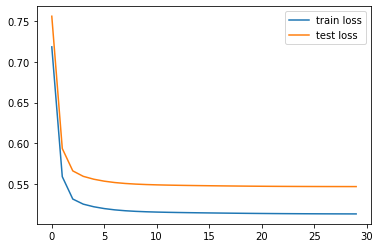

In [15]:
%matplotlib inline
x = list(range(epochs))
plt.plot(x,train_loss, label='train loss')
plt.plot(x,test_loss, label='test loss')
plt.legend()
plt.show()

These train and test loss are lower than those of user - user and item - item based collborative filtering and the model takes much less time to train

A keras based implementation is also possible